[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


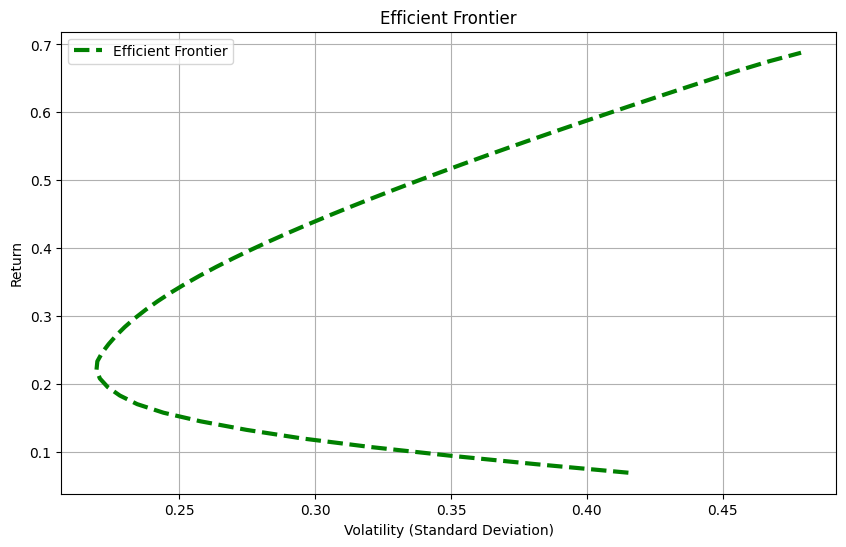

Portfolio Metrics:
Return: 0.3067680759654873
Volatility: 0.2594922000962868
Sharpe Ratio: -0.03384558904644316
Sortino Ratio: -0.045593370933788735
Treynor Ratio: -0.005263648626820643
Beta: 1.6685510352010786


In [133]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define the list of tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NFLX', 'NVDA', 'BABA', 'JPM']

# Define the date range
start_date = '2010-04-01'
end_date = '2024-07-17'

# Download the adjusted closing prices of the stocks
stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Download S&P 500 index data
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']


# Calculate daily returns
stock_returns = stock_data.pct_change().dropna()
sp500_returns = sp500_data.pct_change().dropna()
stock_returns['^GSPC'] = sp500_returns



# Portfolio analysis metrics function
def calculate_portfolio_metrics(weights, returns, benchmark_returns, risk_free_rate=0.01):
    # Calculate portfolio return
    portfolio_return = np.sum(weights * returns.mean()) * 252
    
    # Calculate portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    
    # Calculate Sharpe ratio
    excess_returns = returns - risk_free_rate  # Excess returns over risk-free rate
    sharpe_ratio = np.sum(weights * excess_returns.mean()) / portfolio_volatility
    
    # Calculate Sortino ratio
    downside_returns = returns[returns < risk_free_rate]  # Returns below risk-free rate
    downside_volatility = np.sqrt(np.dot(weights.T, np.dot(downside_returns.cov() * 252, weights)))
    sortino_ratio = np.sum(weights * excess_returns.mean()) / downside_volatility
    
    # Calculate portfolio beta
    covariance_matrix = np.cov(returns.T, benchmark_returns.T)
    portfolio_beta = covariance_matrix[0, 1] / benchmark_returns.var()
    
    # Calculate Treynor ratio
    treynor_ratio = np.sum(weights * excess_returns.mean()) / portfolio_beta
    
    return {
        'Return': portfolio_return,
        'Volatility': portfolio_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Treynor Ratio': treynor_ratio,
        'Beta': portfolio_beta
    }



# Optimization functions
def portfolio_return(weights, returns):
    return np.sum(weights * returns.mean()) * 252

def portfolio_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    portfolio_return = np.sum(weights * returns.mean()) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess
initial_weights = [1 / len(tickers)] * len(tickers)

# Perform optimization to find the efficient frontier
def calculate_efficient_frontier(returns):
    target_returns = np.linspace(min(returns.mean()) * 252, max(returns.mean()) * 252, 50)
    efficient_portfolios = []

    for target_return in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, returns) - target_return}
        )
        result = minimize(portfolio_volatility, initial_weights, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)
        efficient_portfolios.append(result.x)

    return target_returns, efficient_portfolios

# Plot efficient frontier
def plot_efficient_frontier(target_returns, efficient_portfolios, returns):
    plt.figure(figsize=(10, 6))
    portfolio_returns = [portfolio_return(weights, returns) for weights in efficient_portfolios]
    portfolio_volatilities = [portfolio_volatility(weights, returns) for weights in efficient_portfolios]
    
    plt.plot(portfolio_volatilities, portfolio_returns, 'g--', linewidth=3, label='Efficient Frontier')
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate portfolio metrics for equal-weighted portfolio
equal_weights = np.array([1 / len(tickers)] * len(tickers))
# Calculate and plot the efficient frontier
target_returns, efficient_portfolios = calculate_efficient_frontier(stock_returns[tickers])
plot_efficient_frontier(target_returns, efficient_portfolios, stock_returns[tickers])


# Example: Calculate portfolio metrics for equal-weighted portfolio
equal_weights = np.array([1 / len(tickers)] * len(tickers))

# Example: Calculate and print portfolio metrics
portfolio_metrics = calculate_portfolio_metrics(equal_weights, stock_returns[tickers], stock_returns['^GSPC'])
print("Portfolio Metrics:")
for key, value in portfolio_metrics.items():
    print(f"{key}: {value}")
